# NLP classification - supervised learning

In this example, you will learn how you can use supervised learning algorithms for NLP classification. We will use documents from mtsamples again. The task is to classify a document into its clinical specialty, e.g. pediatrics or hematology.

We will use classification algorithms as implemented in sci-kit learn, and evaluate with cross-validation before testing on unseen test data.

Written by Sumithra Velupillai, March 2019

In [1]:
%matplotlib inline

import matplotlib

import pandas as pd

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score

from nltk.tokenize import word_tokenize

import numpy as np

import matplotlib.pyplot as plt

import warnings; warnings.simplefilter('ignore')


# 1: Corpus
Read in the training data.

In [2]:

xlds_training = 'https://github.com/KCL-Health-NLP/nlp_examples/blob/master/classification/classification_trainingdata.xlsx?raw=true'
trainingdata = pd.read_excel(xlds_training)



Take a look at the content. What are the labels we want to try to learn? How many instances do we have?

In [3]:
trainingdata['label'].value_counts()

hematology              81
pediatrics              63
pain                    56
psychiatrypsychology    48
Name: label, dtype: int64

What types of features do you think would be useful for the classification task? Where can we get them? Take a look at one or two of the documents. Can you guess which classification label these belong to?

In [4]:
trainingtxt_example = trainingdata['txt'].tolist()[0]
print(trainingtxt_example)


        
        

        
        
REASON FOR CONSULTATION:
  Thrombocytopenia.


HISTORY OF PRESENT ILLNESS:
  Mrs. XXX is a 17-year-old lady who is going to be 18 in about 3 weeks.  She has been referred for the further evaluation of her thrombocytopenia.  This thrombocytopenia was detected on a routine blood test performed on the 10th of June 2006.  Her hemoglobin was 13.3 with white count of 11.8 at that time.  Her lymphocyte count was 6.7.  The patient, subsequently, had a CBC repeated on the 10th at Hospital where her hemoglobin was 12.4 with a platelet count of 26,000.  She had a repeat of her CBC again on the 12th of June 2006 with hemoglobin of 14, white count of 11.6 with an increase in the number of lymphocytes.  Platelet count was 38.  Her rapid strep screen was negative but the infectious mononucleosis screen is positive.  The patient had a normal platelet count prior too and she is being evaluated for this low platelet count.

The patient gives a history of feeling gen

In [5]:
trainingtxt_example = trainingdata['txt'].tolist()[231]
print(trainingtxt_example)


        
        

        
        
CHIEF COMPLAINT:
  Head injury.


HISTORY: 
 This 16-year-old female presents to Children's Hospital via paramedic ambulance with a complaint at approximately 6 p.m. while she was at band practice using her flag device.  She struck herself in the head with the flag.  There was no loss of consciousness.  She did feel dizzy.  She complained of a headache.  She was able to walk.  She continued to participate in her flag practice.  She got dizzier.  She sat down for a while and walked and during the second period of walking, she had some episodes of diplopia, felt that she might faint and was assisted to the ground and was transported via paramedic ambulance to Children's Hospital for further evaluation.


PAST MEDICAL HISTORY: 
 Hypertension.


ALLERGIES:
  DENIED TO ME; HOWEVER, IT IS NOTED BEFORE SEVERAL ACCORDING TO MEDITECH.


CURRENT MEDICATIONS: 
 Enalapril.


PAST SURGICAL HISTORY: 
 She had some kind of an abdominal obstruction as an infant.



The most common baseline feature representation for text classification tasks is to use the bag-of-words representation, in a document-term matrix. Let's build a simple one using raw counts and only keeping a maximum of 500 features. We can use the CountVectorizer function from sklearn, and tokenize using a function from nltk.

In [6]:
first_vectorizer = CountVectorizer(ngram_range=(1,1), stop_words=None,
                             tokenizer=word_tokenize, max_features=500)
first_vectorizer.fit(trainingdata['txt'].tolist())
first_fit_transformed_data = first_vectorizer.fit_transform(trainingdata['txt'])


We can now look at this transformed representation for an example document.

In [7]:
first_transformed_data = first_vectorizer.transform([trainingdata['txt'].tolist()[231]])
print (first_transformed_data)

  (0, 3)	3
  (0, 6)	29
  (0, 8)	56
  (0, 13)	1
  (0, 16)	1
  (0, 23)	1
  (0, 24)	22
  (0, 25)	1
  (0, 27)	8
  (0, 30)	2
  (0, 31)	2
  (0, 32)	1
  (0, 33)	1
  (0, 45)	2
  (0, 46)	1
  (0, 47)	1
  (0, 51)	2
  (0, 52)	15
  (0, 55)	1
  (0, 59)	1
  (0, 60)	1
  (0, 61)	5
  (0, 64)	1
  (0, 68)	5
  (0, 70)	1
  :	:
  (0, 414)	1
  (0, 424)	1
  (0, 426)	1
  (0, 427)	1
  (0, 429)	2
  (0, 433)	1
  (0, 436)	1
  (0, 437)	11
  (0, 441)	4
  (0, 443)	1
  (0, 444)	2
  (0, 453)	15
  (0, 464)	1
  (0, 468)	1
  (0, 472)	1
  (0, 474)	6
  (0, 476)	1
  (0, 478)	1
  (0, 484)	1
  (0, 485)	2
  (0, 487)	1
  (0, 490)	9
  (0, 491)	1
  (0, 492)	4
  (0, 495)	1


What word is represented by the different indices? Have a look at a few examples.

In [8]:
print (first_vectorizer.get_feature_names()[30])

abdomen


In [9]:
print(first_fit_transformed_data.shape)
print ('Amount of Non-Zero occurences: ', first_fit_transformed_data.nnz)

(248, 500)
Amount of Non-Zero occurences:  30367


Let's build a classifier with this feature representation.

In [10]:
multinomialNB_classifier = MultinomialNB().fit(first_fit_transformed_data, trainingdata['label'])

We now have a trained multinomial Naive Bayes model. But how do we know how well it works? Let's evaluate it on the test data.

In [11]:

xlds_test = 'https://github.com/KCL-Health-NLP/nlp_examples/blob/master/classification/classification_test_data.xlsx?raw=true'
testdata = pd.read_excel(xlds_test)



## We need to transform this data to the same representation
first_fit_transformed_testdata = first_vectorizer.transform(testdata['txt'])

In [12]:
first_fit_transformed_testdata
multinomialNB_predicted = multinomialNB_classifier.predict(first_fit_transformed_testdata)
multinomialNB_predicted

array(['pain', 'hematology', 'pain', 'pain', 'pediatrics', 'hematology',
       'pediatrics', 'hematology', 'psychiatrypsychology', 'pain',
       'hematology', 'pediatrics', 'pain', 'psychiatrypsychology', 'pain',
       'hematology', 'pediatrics', 'pain', 'pain', 'psychiatrypsychology',
       'pediatrics', 'pain', 'hematology', 'psychiatrypsychology',
       'psychiatrypsychology', 'hematology', 'psychiatrypsychology'],
      dtype='<U20')

In [13]:
print(metrics.classification_report(testdata['label'], multinomialNB_predicted, target_names=set(testdata['label'].tolist())))

                      precision    recall  f1-score   support

          pediatrics       0.86      0.67      0.75         9
                pain       0.67      1.00      0.80         6
          hematology       0.80      0.57      0.67         7
psychiatrypsychology       0.83      1.00      0.91         5

            accuracy                           0.78        27
           macro avg       0.79      0.81      0.78        27
        weighted avg       0.80      0.78      0.77        27



This didn't look too bad maybe? But there are probably ways of improving this, by changing the feature space or maybe trying a different classifier model. 
__There is one main problem though: we can't use this test data to try different configurations! Why?__

We can however try some different feature representations and classifier algorithms on the training data. Let's try finding a model we think will work well on unseen data by employing n-fold cross-validation.

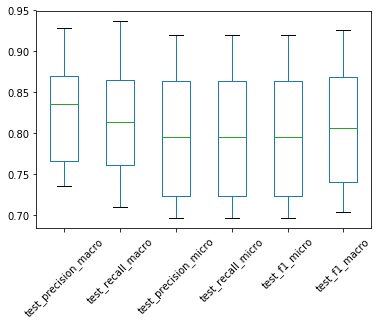

In [14]:
multinomialNB_classifier = MultinomialNB().fit(first_fit_transformed_data, trainingdata['label'])
scoring = ['precision_macro', 'recall_macro','precision_micro','recall_micro', 'f1_micro', 'f1_macro']
scores = cross_validate(multinomialNB_classifier, first_fit_transformed_data, trainingdata['label'], scoring=scoring, cv=10, return_train_score=False)
scoresdf = pd.DataFrame(scores)
scoring = ['test_precision_macro', 'test_recall_macro','test_precision_micro','test_recall_micro', 'test_f1_micro', 'test_f1_macro']
bp = scoresdf.boxplot(column=scoring, grid=False, rot=45,)
[ax_tmp.set_xlabel('') for ax_tmp in np.asarray(bp).reshape(-1)]
fig = np.asarray(bp).reshape(-1)[0].get_figure()
plt.show()

What happens if we try another classifier? Let's try a random forest classifier.

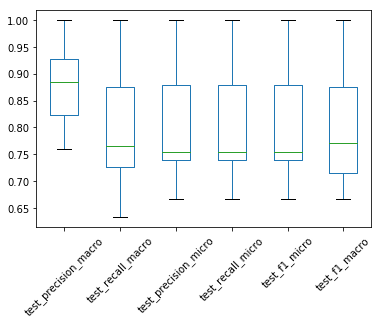

In [15]:
rf_classifier = RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0).fit(first_fit_transformed_data, trainingdata['label'])
scoring = ['precision_macro', 'recall_macro','precision_micro','recall_micro', 'f1_micro', 'f1_macro']
scores = cross_validate(rf_classifier, first_fit_transformed_data, trainingdata['label'], scoring=scoring, cv=10, return_train_score=False)
scoresdf = pd.DataFrame(scores)
scoring = ['test_precision_macro', 'test_recall_macro','test_precision_micro','test_recall_micro', 'test_f1_micro', 'test_f1_macro']
bp = scoresdf.boxplot(column=scoring, grid=False, rot=45,)
[ax_tmp.set_xlabel('') for ax_tmp in np.asarray(bp).reshape(-1)]
fig = np.asarray(bp).reshape(-1)[0].get_figure()
plt.show()

Was this better or worse? Are there any parameters worth changing?

We have used a very simple bag-of-words representation. What happens if we try something else? Let's try tf-idf. This is considered a strong baseline in many text classification tasks.

In [16]:
from nltk.corpus import stopwords
stopWords = set(stopwords.words('english'))
tfidf_vect = TfidfVectorizer(tokenizer=word_tokenize, stop_words=stopWords)
tfidf_vect.fit(trainingdata['txt'])
second_fit_transformed_data =  tfidf_vect.transform(trainingdata['txt'])
second_fit_transformed_data

<248x10328 sparse matrix of type '<class 'numpy.float64'>'
	with 55265 stored elements in Compressed Sparse Row format>

What other parameters can you change in this representation? How does this look different from the CountVectorizer representation?

Let's now use this with the Multinomial Naive Bayes classifier.

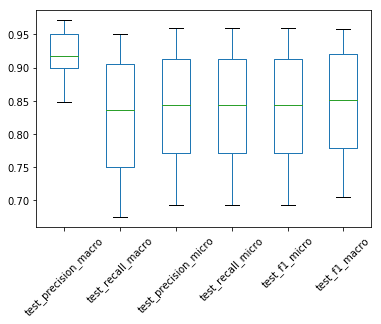

In [17]:
multinomialNB_classifier = MultinomialNB().fit(second_fit_transformed_data, trainingdata['label'])
scoring = ['precision_macro', 'recall_macro','precision_micro','recall_micro', 'f1_micro', 'f1_macro']
scores = cross_validate(multinomialNB_classifier, second_fit_transformed_data, trainingdata['label'], scoring=scoring, cv=10, return_train_score=False)
scoresdf = pd.DataFrame(scores)
scoring = ['test_precision_macro', 'test_recall_macro','test_precision_micro','test_recall_micro', 'test_f1_micro', 'test_f1_macro']
bp = scoresdf.boxplot(column=scoring, grid=False, rot=45,)
[ax_tmp.set_xlabel('') for ax_tmp in np.asarray(bp).reshape(-1)]
fig = np.asarray(bp).reshape(-1)[0].get_figure()
plt.show()

This looks better, doesn't it? Let's try some different configurations all in one go.

representation:  CountVectorizer


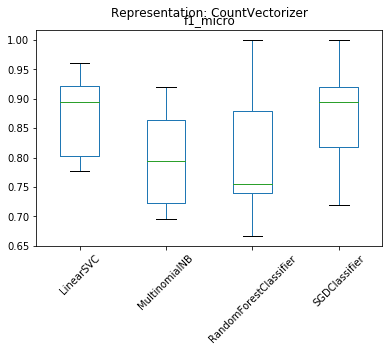

representation:  TfidfVectorizer


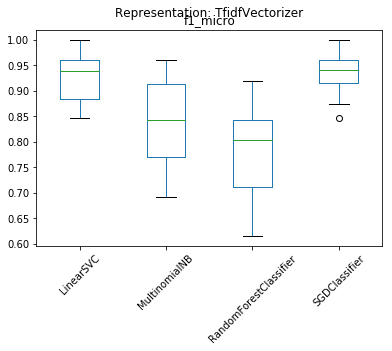

In [18]:
## material in parts from https://towardsdatascience.com/multi-class-text-classification-with-scikit-learn-12f1e60e0a9f

representations = {}

vectorizer = CountVectorizer(ngram_range=(1,1), stop_words=None,
                             tokenizer=word_tokenize, max_features=500)
xtrain_countvect = vectorizer.fit_transform(trainingdata['txt'])
representations['CountVectorizer'] = xtrain_countvect

tfidf_vect = TfidfVectorizer(tokenizer=word_tokenize, stop_words=stopWords)
tfidf_vect.fit(trainingdata['txt'])
xtrain_tfidf =  tfidf_vect.transform(trainingdata['txt'])
representations['TfidfVectorizer'] = xtrain_tfidf



for representation, transformed_vector in representations.items():
    classifier_models = [
        RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
        LinearSVC(multi_class='ovr', C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
      penalty='l2', random_state=0, tol=1e-05, verbose=0),
        MultinomialNB(),
        #LogisticRegression(random_state=0),
        SGDClassifier(),
    ]
    CV = 10
    cv_df = pd.DataFrame(index=range(CV * len(classifier_models)))
    score = 'f1_micro'
    entries = []
    for model in classifier_models:
      model_name = model.__class__.__name__
      accuracies = cross_val_score(model, transformed_vector, trainingdata['label'], scoring=score, cv=CV)
      for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
    cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', score])

    print('representation: ', representation)
    bp = cv_df.boxplot(by='model_name', column=[score], grid=False, rot=45,)
    [ax_tmp.set_xlabel('') for ax_tmp in np.asarray(bp).reshape(-1)]
    fig = np.asarray(bp).reshape(-1)[0].get_figure()
    fig.suptitle('Representation: '+representation)
    plt.show()

What conclusions do you draw from this? Which classifier and which representation would you choose as your final model? Why?

# Assignment 1: Your turn to build a classifier
**Choose one classifier and one representation format and test it on the test data. What results do you get?** 

***What other configurations could you try before deciding on a final model? Is it appropriate to experiment with this on the test data? Why or why not?*** 

In [19]:
## First step: Transform your training and test data to your chosen representation. 

## choose a representation: CountVectorizer or TfidfVectorizer
chosen_vectorizer = 

## transform the training data 
fit_transformed_training_data = chosen_vectorizer.fit_transform(trainingdata['txt'])

## transform the test data
transformed_test_data = chosen_vectorizer.transform(testdata['txt'])

## Second step: Create a classifier - the one you think gave best results when experimenting with cross-validation

chosen_classifier 

## train the classifier on the training data
chosen_classifier.fit(fit_transformed_training_data, trainingdata['label'])
## predict labels on the test data
predicted = chosen_classifier.predict(transformed_test_data)
## what results do you get? 
print(metrics.classification_report(testdata['label'], predicted, target_names=set(testdata['label'].tolist())))

SyntaxError: invalid syntax (<ipython-input-19-97b7f3507ded>, line 4)

**What happens if you try to predict a label with a completely new text using your chosen trained classifier model? Does it seem to classify correctly?**

In [ ]:
new_text = 'Patient with severe depression.'
testX = chosen_vectorizer.transform([new_text])
predicted = chosen_classifier.predict(testX)
print(predicted)

In [ ]:
new_text = '5-year old girl with asthma.'
testX = chosen_vectorizer.transform([new_text])
predicted = chosen_classifier.predict(testX)
print(predicted)

In [ ]:
new_text = 'Her pain is severe.'
testX = chosen_vectorizer.transform([new_text])
predicted = chosen_classifier.predict(testX)
print(predicted)

# Assignment 2: Evaluation

**Write ten example sentences or paragraphs where you assign the correct label to each of them. Then pass them to the classifier and calculate precision, recall and f-score. Analyse and discuss the results.**

***Gold label values: psychiatrypsychology, hematology, pain, pediatrics***

In [ ]:
new_text = ## Choose a representation for the example sentences/paragraphs and their gold labels (e.g. lists, dict, dataframe)

testX = chosen_vectorizer.transform(##pass the example texts here)
predicted = chosen_classifier.predict(testX)

## compare the predicted labels with the gold labels and calculate precision, recall and f1-score. 
# HINT: metrics.classification_report is useful here
